In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, f1_score)

In [8]:
raw_data_path = '../data/raw/loan_default.csv'
df = pd.read_csv(raw_data_path)

In [9]:
df.info

<bound method DataFrame.info of             LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
0       I38PQUQS96   56   85994       50587          520              80   
1       HPSK72WA7R   69   50432      124440          458              15   
2       C1OZ6DPJ8Y   46   84208      129188          451              26   
3       V2KKSFM3UN   32   31713       44799          743               0   
4       EY08JDHTZP   60   20437        9139          633               8   
...            ...  ...     ...         ...          ...             ...   
255342  8C6S86ESGC   19   37979      210682          541             109   
255343  98R4KDHNND   32   51953      189899          511              14   
255344  XQK1UUUNGP   56   84820      208294          597              70   
255345  JAO28CPL4H   42   85109       60575          809              40   
255346  ZTH91CGL0B   62   22418       18481          636             113   

        NumCreditLines  InterestRate  LoanTerm  DTIRati

In [10]:
df.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


In [11]:
df.dtypes

LoanID             object
Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
NumCreditLines      int64
InterestRate      float64
LoanTerm            int64
DTIRatio          float64
Education          object
EmploymentType     object
MaritalStatus      object
HasMortgage        object
HasDependents      object
LoanPurpose        object
HasCoSigner        object
Default             int64
dtype: object

**Данные выглядит логично, противоречий нет**

In [12]:
missing_values = df.isna().sum() #проверка на пропуски
print(missing_values)

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64


**Пропусков нет**

In [13]:
df["Default"].value_counts(normalize=True)

Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64

**88% — без дефолта
11% — дефолт**

In [14]:
df.groupby("Default")["Income"].median()

Default
0    84237.5
1    66566.0
Name: Income, dtype: float64

**Клиенты с дефолтом в среднем имеют более низкий доход, что соответствует логике**

# Датасет представляет собой крупный и реалистичный набор кредитных данных c понятными признаками, качество данных высокое, что делает датасет подходящим для построения и последующей валидации моделей кредитного риска.

In [15]:
df = df.drop('LoanID', axis=1) #Удаляем ID

**Преобразуем категориальные переменные в фиктивные и бинарные**

In [16]:
df['HasMortgage'] = df['HasMortgage'].map({'Yes': 1, 'No': 0}) #Превращаем переменные в бинарные
df['HasDependents'] = df['HasDependents'].map({'Yes': 1, 'No': 0})
df['HasCoSigner'] = df['HasCoSigner'].map({'Yes': 1, 'No': 0})

In [17]:
df = pd.get_dummies(df, columns=['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose'], drop_first=True) 

**Разделяем выборки на обучающую и тестовую**

In [18]:
X = df.drop('Default', axis=1) #Столбцы без целевой переменной
y = df['Default'] #целевая переменная

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=69, stratify=y
) 

**Масштабирование**

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # c fit потому что обучающая
X_test_scaled = scaler.transform(X_test)

**Логистическая регрессия**

In [20]:
log_reg = LogisticRegression(random_state=69, max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_pred_log = log_reg.predict(X_test_scaled)
y_pred_proba_log = log_reg.predict_proba(X_test_scaled)[:, 1]

In [21]:
y_pred_proba_log

array([0.24534069, 0.48854476, 0.33956581, ..., 0.14846142, 0.74950146,
       0.49828111])

**Градиентный бустинг**

In [22]:
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=69,
    subsample=0.8
)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test) #Предсказание классов (0 или 1)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1] #Предсказание вероятности получить класс 1

In [23]:
y_pred_proba_gb

array([0.05005148, 0.09201932, 0.04923561, ..., 0.02356792, 0.21480719,
       0.08875566])

**Интерпретация**

In [24]:
print("Допустим, для клиента №48:")
print("Логистическая регрессия:", "Дефолт" if y_pred_log[48] == 1 else "НЕ ДЕФОЛТ","c вероятностью", round(y_pred_proba_log[48]*100,0),"%")

print("Градиентный бустинг:", "Дефолт" if y_pred_gb[48] == 1 else "НЕ ДЕФОЛТ","c вероятностью", round(y_pred_proba_gb[48]*100,0),"%")

Допустим, для клиента №48:
Логистическая регрессия: Дефолт c вероятностью 62.0 %
Градиентный бустинг: НЕ ДЕФОЛТ c вероятностью 20.0 %


**Матрицы ошибок**

In [25]:
cm_log = confusion_matrix(y_test, y_pred_log)
print(cm_log)

[[30432 14707]
 [ 1880  4051]]


In [34]:
cm_gb = confusion_matrix(y_test, y_pred_gb)
print(cm_gb)

[[44961   178]
 [ 5603   328]]


**Функции для расчета метрик**

In [26]:
#Коэффициент Джини 
def calculate_gini(y_true, y_pred_proba):
    roc_auc = roc_auc_score(y_true, y_pred_proba) 
    return 2 * roc_auc - 1

#KS статистика - через ROC кривую
def calculate_ks(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)  # строим ROC кривую
    ks = np.max(tpr - fpr)
    return ks

**Метрики**

In [27]:
metrics_results = {}  # словарь для метрик


In [28]:
#Метрики для лог модели
metrics_results['logistic'] = {
    'accuracy': accuracy_score(y_test, y_pred_log),    # общая точность: (TP+TN)/все
    'precision': precision_score(y_test, y_pred_log),  # точность дефолтов: TP/(TP+FP)
    'recall': recall_score(y_test, y_pred_log),        # полнота: TP/(TP+FN) - сколько дефолтов нашли
    'f1': f1_score(y_test, y_pred_log),               # среднее гармоническое precision и recall
    'roc_auc': roc_auc_score(y_test, y_pred_proba_log),  # площадь под ROC-кривой
    'gini': calculate_gini(y_test, y_pred_proba_log),  # коэффициент Джини
    'ks': calculate_ks(y_test, y_pred_proba_log)       # KS статистика
}
#Метрики для градиентного бустинга
metrics_results['gradient_boosting'] = {
    'accuracy': accuracy_score(y_test, y_pred_gb),
    'precision': precision_score(y_test, y_pred_gb),
    'recall': recall_score(y_test, y_pred_gb),
    'f1': f1_score(y_test, y_pred_gb),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_gb),
    'gini': calculate_gini(y_test, y_pred_proba_gb),
    'ks': calculate_ks(y_test, y_pred_proba_gb)
}

In [29]:
print(metrics_results)

{'logistic': {'accuracy': 0.6752104953984727, 'precision': 0.2159611898923126, 'recall': 0.6830214129151914, 'f1': 0.3281623395034226, 'roc_auc': 0.742700896220789, 'gini': 0.4854017924415781, 'ks': 0.358786639186104}, 'gradient_boosting': {'accuracy': 0.8868024280399451, 'precision': 0.6482213438735178, 'recall': 0.05530264710841342, 'f1': 0.10191082802547771, 'roc_auc': 0.7474109114741098, 'gini': 0.4948218229482195, 'ks': 0.37100435628109424}}


**Визуализация**

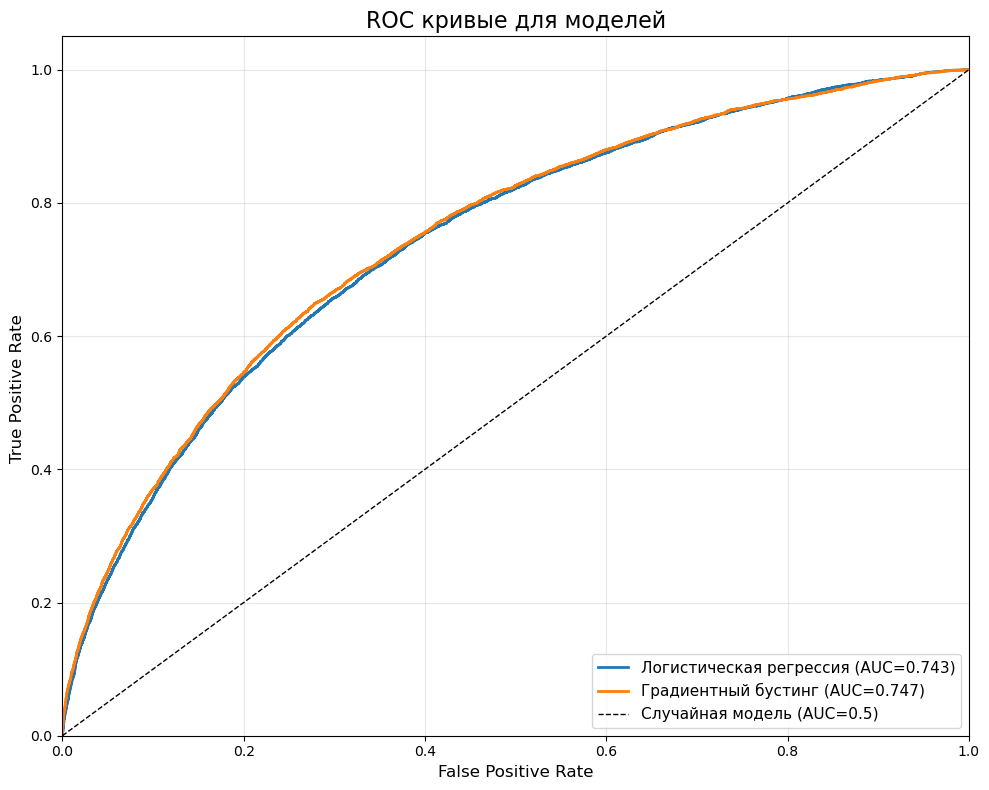

In [30]:
#ROC-кривые
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_proba_log)  # точки для логистической регрессии
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)     # точки для градиентного бустинга

plt.figure(figsize=(10, 8))

# Строим ROC-кривые для обеих моделей
plt.plot(fpr_log, tpr_log, label=f'Логистическая регрессия (AUC={metrics_results["logistic"]["roc_auc"]:.3f})', linewidth=2)
plt.plot(fpr_gb, tpr_gb, label=f'Градиентный бустинг (AUC={metrics_results["gradient_boosting"]["roc_auc"]:.3f})', linewidth=2)

# Диагональ - случайная модель (AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', label='Случайная модель (AUC=0.5)', linewidth=1)

# Настройки графика
plt.xlabel('False Positive Rate', fontsize=12)  
plt.ylabel('True Positive Rate ', fontsize=12)  
plt.title('ROC кривые для моделей', fontsize=16)
plt.legend(loc='lower right', fontsize=11) 
plt.grid(True, alpha=0.3) 
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.tight_layout()
plt.show()

In [31]:
if metrics_results['gradient_boosting']['roc_auc'] > metrics_results['logistic']['roc_auc']:
    print("Градиентный бустинг лучше по ROC-AUC")
    best_model = "Градиентный бустинг"
    best_auc = metrics_results['gradient_boosting']['roc_auc']
else:
    print("Логистическая регрессия лучше по ROC-AUC")
    best_model = "Логистическая регрессия"
    best_auc = metrics_results['logistic']['roc_auc']

Градиентный бустинг лучше по ROC-AUC


**Важные признаки моделей**

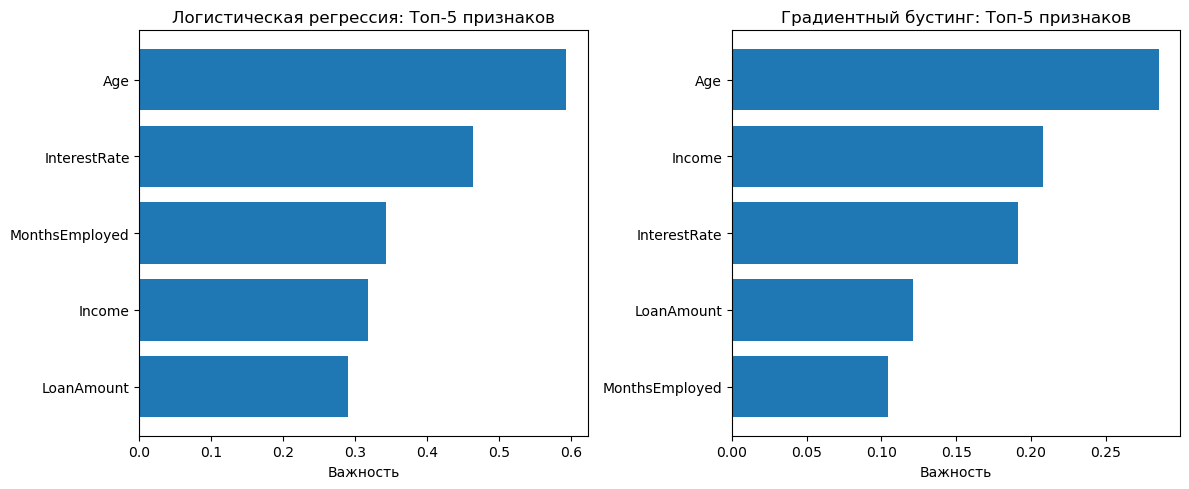

In [32]:
top_features_log = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(log_reg.coef_[0])
}).sort_values('importance', ascending=False).head(5)

top_features_gb = pd.DataFrame({
    'feature': X.columns,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False).head(5)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Логистическая регрессия
axes[0].barh(top_features_log['feature'], top_features_log['importance'])
axes[0].set_title('Логистическая регрессия: Топ-5 признаков')
axes[0].set_xlabel('Важность')
axes[0].invert_yaxis()

# Градиентный бустинг
axes[1].barh(top_features_gb['feature'], top_features_gb['importance'])
axes[1].set_title('Градиентный бустинг: Топ-5 признаков')
axes[1].set_xlabel('Важность')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ
==================================================

# Самые важные признаки:
**Логистическая регрессия:**
Age
InterestRate
MonthsEmployed
Income
LoanAmount

**Градиентный бустинг:**
Age
Income
InterestRate
LoanAmount
MonthsEmployed

# Сравнение моделей:

**Метрики качества:**

**Логистическая регрессия:**
ROC-AUC: 0.743
Gini: 0.485
KS: 0.359

**Градиентный бустинг:**
ROC-AUC: 0.747
Gini: 0.495
KS: 0.371

# Выводы

Градиентный бустинг лучше (AUC: 0.747 vs 0.743)

Логистическая регрессия проще для интерпретации

Важные признаки видны из коэффициентов логистической регрессии

Модели можно использовать для оценки кредитного риска